In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
# Process the content and style image

height = 400
width = 400

contentImagePath = 'content3.jpg'
contentImage = Image.open(contentImagePath)
contentImage = contentImage.resize((height,width))

In [3]:
# contentImage

In [4]:
styleImagePath = 'style2.jpg'
styleImage = Image.open(styleImagePath)
styleImage = styleImage.resize((height,width))

In [5]:
# styleImage

In [6]:
contentArray = np.asarray(contentImage,dtype = 'float32')
contentArray = np.expand_dims(contentArray,axis = 0)

In [7]:
contentArray.shape

(1, 400, 400, 3)

In [8]:
styleArray = np.asarray(styleImage,dtype = 'float32')
styleArray = np.expand_dims(styleArray,axis = 0)

In [9]:
styleArray.shape

(1, 400, 400, 3)

In [10]:
# acc to vgg16 we need to do 2 transformations

# 1. find mean of rgb from ur image and subtract it 
contentArray[:,:,:,0] -= 100.21
contentArray[:,:,:,1] -= 115.75
contentArray[:,:,:,2] -= 118.56

# 2. flip the image from rgb to bgr
contentArray = contentArray[:,:,:,::-1]

In [11]:
styleArray[:,:,:,0] -= 100.21
styleArray[:,:,:,1] -= 115.75
styleArray[:,:,:,2] -= 118.56

styleArray = styleArray[:,:,:,::-1]

In [12]:
contentImage = backend.variable(contentArray)
styleImage = backend.variable(styleArray)

combinationImage = backend.placeholder((1,height,width,3))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
inputTensor = backend.concatenate([contentImage,styleImage,combinationImage], axis = 0)

In [14]:
model = VGG16(input_tensor = inputTensor, weights = 'imagenet', include_top=False)

In [15]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [16]:
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 400, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 400, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 200, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 200, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 100, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 100, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 100, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 50, 256) dtype=float32>,
 'block4_conv1': <t

In [17]:
# contentLoss, styleLoss, totalVariationLoss
contentWeight = 0.025
styleWeight = 5.0
totalVariationWeight = 1.0

In [18]:
loss = backend.variable(0.)

In [19]:
# content loss is euclidean distance b/w feature representations of content and combination image
def contentLoss(content,combination):
    return backend.sum(backend.square(combination - content))

In [20]:
layer_features = layers['block2_conv2']
contentImageFeatures = layer_features[0,:,:,:]
combinationImageFeatures = layer_features[2,:,:,:]

In [21]:
loss += contentWeight * contentLoss(contentImageFeatures, combinationImageFeatures)

In [22]:
# StyleLoss
# we define a gram matrix
# this matrix is proportional to the covariance of corresponding sets of features, and it captures
# information about which feature tend to activate together

def gramMatrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features,backend.transpose(features))
    return gram

In [23]:
def styleLoss(style,combination):
    s = gramMatrix(style)
    c = gramMatrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(s-c))/(4 * (channels ** 2) * (size ** 2))

In [24]:
featureLayers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

In [25]:
for layerName in featureLayers:
    layer_feature = layers[layerName]
    style_feature = layer_features[1,:,:,:]
    combination_feature = layer_features[2,:,:,:]
    s_loss = styleLoss(style_feature, combination_feature)
    loss += (styleWeight / len(featureLayers)) * s_loss

In [26]:
# total variation loss
# we add another term that is total variation loss (a regularization term)

def totalVariationLoss(x):
    a = backend.square(x[:, :height-1, :width-1 :] -x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1 :] -x[:, 1:, :width-1, :])
    return backend.sum(backend.pow(a+b,1.0))

In [27]:
loss += totalVariationWeight * totalVariationLoss(combinationImage)

In [28]:
grad = backend.gradients(loss, combinationImage)

In [29]:
# we now compute loss and gradients in one pass while fetch them into two separate functions
# loss and grad, because of spicy.optimize, it requires separate functions for loss and grads
outputs = [loss]
outputs += grad
f_output = backend.function([combinationImage], outputs)

In [30]:
def eval_loss_and_grad(x):
    x = x.reshape((1,height,width,3))
    out = f_output([x])
    loss_value = out[0]
    grad_value = out[1].flatten().astype('float64')
    return loss_value, grad_value

In [31]:
class Evaluate():
    def __init__(self):
        self.loss_value = None
        self.grad_value = None
        
    def loss(self,x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grad(x)
        self.loss_value = loss_value
        self.grad_value = grad_value
        return self.loss_value
    
    def grads(self,x):
        assert self.loss_value is not None
        grad_value = np.copy(self.grad_value)
        self.loss_value = None
        self.grad_value = None
        return grad_value
    
evaluate = Evaluate()

Start 0
Current Loss 137687290000.0
Iteration completed in 113.81387639045715 sec.
#####################################################
Start 1
Current Loss 80702110000.0
Iteration completed in 110.26981854438782 sec.
#####################################################
Start 2
Current Loss 61766353000.0
Iteration completed in 111.12959885597229 sec.
#####################################################
Start 3
Current Loss 51955974000.0
Iteration completed in 173.50691080093384 sec.
#####################################################
Start 4
Current Loss 44874072000.0
Iteration completed in 93.85518860816956 sec.
#####################################################
Start 5
Current Loss 39135064000.0
Iteration completed in 78.33572554588318 sec.
#####################################################
Start 6
Current Loss 35158147000.0
Iteration completed in 81.3120973110199 sec.
#####################################################
Start 7
Current Loss 32276232000.0
Iteration comple

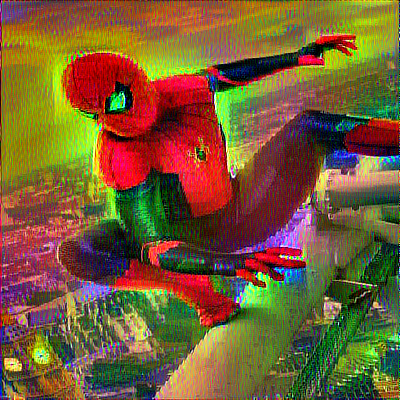

In [32]:
# now we will use L-BFGS algorithm(quasi-Newton algorithm which is quicker than normal gradient descent)
x = np.random.uniform(0,255,(1,height,width,3)) - 128.
epochs = 50

for i in range(epochs):
    print("Start",i)
    start_time = time.time()
    x,loss_val,info = fmin_l_bfgs_b(evaluate.loss, x.flatten(), fprime = evaluate.grads, maxfun=20)
    print("Current Loss", loss_val)
    end_time = time.time()
    total_time = end_time - start_time
    print("Iteration completed in",total_time,"sec.")
    print("#####################################################")
    
x = x.reshape((height,width,3))
x = x[:,:,::-1]
x[:,:,0] += 100.21
x[:,:,1] += 115.75
x[:,:,2] += 118.56

x = np.clip(x,0,255).astype('uint8')
Image.fromarray(x)